In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data

from combinators.inference import conditioning, variational
from combinators.lens import Cap, PRO, Ty
from combinators.model import collections
from combinators import sampler, signal, utils


In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
torch.manual_seed(0xdeadbeef)

In [6]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [7]:
data = torch.load('examples/dynamical_ball/dynamical_ball_data.pt')

In [8]:
def dict_to_tracelike(d):
    return {k: v.expand(1, 1, *v.shape) for k, v in d.items()}

In [9]:
def accumulate_trajectory(p):
    initial_position = p['position_0']
    velocities = torch.zeros(*initial_position.shape[:2], T + 1, 2)
    for t in range(0, T):
        velocities[:, :, t] = p['velocity_%d' % t]
    trajectory = dynamical_ball.simulate_trajectory(initial_position, velocities[:, :, 0], T, velocities=velocities)
    return trajectory[:, :, :, 0, :]

In [10]:
p = dict_to_tracelike(data)
trajectory = torch.stack([p['position_%d' % t] for t in range(T+1)], dim=2)

In [11]:
num_particles = 3
particle_shape = (num_particles,)
batch_shape = (1,)

In [12]:
def accumulate_trajectory(p):
    initial_position = p['position_0'].value
    initial_velocity = p['velocity_0'].value
    velocities = torch.zeros(*initial_velocity.shape[:2], T + 1, 2)
    velocities[:, :, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, :, t] = p['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, :, 0, :]

In [13]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, :, 0], positions[:, :, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [14]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [15]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [16]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))
    
    velocity_steps = velocity_steps.squeeze(-2)
    displacements = displacements.squeeze(-2)

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [17]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [18]:
def training_model():
    init_dynamics = dynamical_ball.InitBallDynamics()
    update = dynamical_ball.InitDynamicsProposal()
    init_dynamics = sampler.importance_box('init_dynamics', init_dynamics, update,
                                           batch_shape, particle_shape, PRO(0), PRO(2))
    init_state = dynamical_ball.InitialBallState()
    update = dynamical_ball.InitBallProposal()
    init_state = sampler.importance_box('init_state', init_state, update,
                                        batch_shape, particle_shape,
                                        PRO(0), PRO(2))
    
    step = dynamical_ball.StepBallState()
    update = dynamical_ball.StepBallProposal()
    step = sampler.importance_box('step_state', step, update, batch_shape, particle_shape, PRO(4), PRO(2))
    
    return (init_state @ init_dynamics) >> collections.sequential_ssm(PRO(2), PRO(2), step, T)

03/15/2022 13:23:13 elbo=-1.37631738e+03 at epoch 1
03/15/2022 13:23:15 elbo=-5.82282959e+02 at epoch 2
03/15/2022 13:23:18 elbo=-4.33901062e+02 at epoch 3
03/15/2022 13:23:21 elbo=-5.33780762e+02 at epoch 4
03/15/2022 13:23:24 elbo=-3.83766083e+02 at epoch 5
03/15/2022 13:23:27 elbo=-4.21890594e+02 at epoch 6
03/15/2022 13:23:30 elbo=-3.89589905e+02 at epoch 7
03/15/2022 13:23:33 elbo=-6.58733521e+02 at epoch 8
03/15/2022 13:23:36 elbo=-3.95539307e+02 at epoch 9
03/15/2022 13:23:38 elbo=-4.12334473e+02 at epoch 10
03/15/2022 13:23:41 elbo=-3.69786560e+02 at epoch 11
03/15/2022 13:23:44 elbo=-5.69723938e+02 at epoch 12
03/15/2022 13:23:47 elbo=-3.52684509e+02 at epoch 13
03/15/2022 13:23:50 elbo=-3.81122528e+02 at epoch 14
03/15/2022 13:23:53 elbo=-3.92604492e+02 at epoch 15
03/15/2022 13:23:55 elbo=-4.04363007e+02 at epoch 16
03/15/2022 13:23:58 elbo=-4.37483826e+02 at epoch 17
03/15/2022 13:24:01 elbo=-4.36045593e+02 at epoch 18
03/15/2022 13:24:03 elbo=-3.70130707e+02 at epoch 19
03

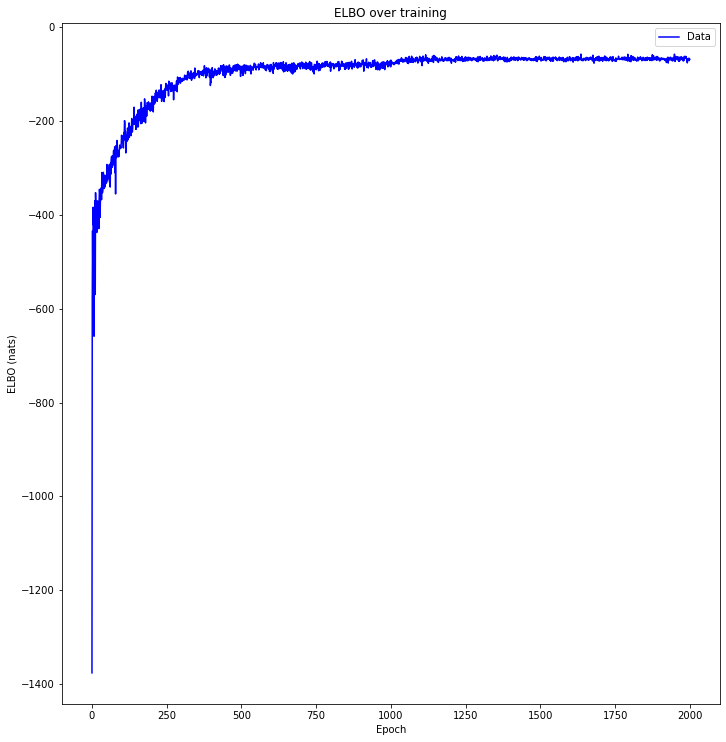

In [19]:
modal_directions = torch.zeros(num_series, K, 2)

data_dicts = [data['position_%d' % t].unsqueeze(dim=0).detach()
              for t in range(T)]

diagram = training_model()
diagram = conditioning.SequentialConditioner(step_state=data_dicts)(diagram)
elbos = variational.infer(diagram, 2000, use_cuda=True, lr=1e-2, patience=100)

utils.plot_evidence_bounds(elbos.detach().numpy(), True)

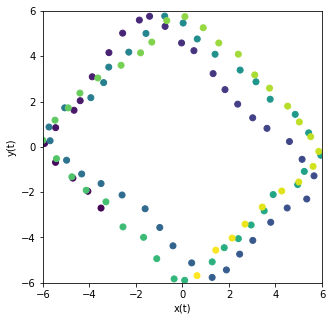

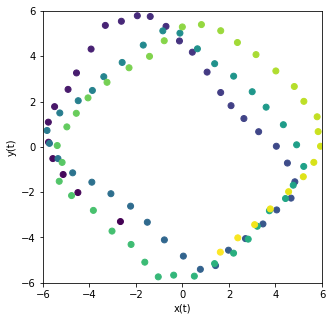

In [20]:
graph = sampler.compile(diagram >> signal.Cap(diagram.cod))
sampler.filter(graph)
sampler.smooth(graph)
p, log_weight = sampler.trace(graph)
inferred_trajectory = accumulate_trajectory(p)

positions = inferred_trajectory.mean(dim=0).cpu().detach()
displacements = torch.stack([p['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).unsqueeze(1).to(displacements), displacements[:-1]), dim=2)
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).unsqueeze(1).to(displacements) + 1, displacements[:-1]), dim=2)
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

graph_original_trajectory(trajectory.squeeze(dim=0), T, 0)
graph_inferred_trajectory(positions, T, 0)
graph_displacement_trajectories(velocity_steps, displacements, T, 0)

plt.close('all')

In [21]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[:, t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[:, t])**2).sum())

Position at time 0 tensor([-3.5021, -2.6996])
Inferred position at time 0 tensor([[-2.6670, -3.2957]])
MSE at time 0 tensor(1.0527)
Position at time 1 tensor([-4.0682, -1.9584])
Inferred position at time 1 tensor([[-4.4975, -2.0159]])
MSE at time 1 tensor(0.1876)
Position at time 2 tensor([-4.7122, -1.3787])
Inferred position at time 2 tensor([[-5.1305, -1.2183]])
MSE at time 2 tensor(0.2008)
Position at time 3 tensor([-5.4583, -0.6825])
Inferred position at time 3 tensor([[-5.5752, -0.5155]])
MSE at time 3 tensor(0.0416)
Position at time 4 tensor([-5.9298,  0.1506])
Inferred position at time 4 tensor([[-5.7612,  0.2072]])
MSE at time 4 tensor(0.0316)
Position at time 5 tensor([-5.4542,  0.8492])
Inferred position at time 5 tensor([[-5.7679,  1.0926]])
MSE at time 5 tensor(0.1577)
Position at time 6 tensor([-4.6626,  1.6177])
Inferred position at time 6 tensor([[-5.4987,  1.7779]])
MSE at time 6 tensor(0.7246)
Position at time 7 tensor([-4.3980,  2.0399])
Inferred position at time 7 te

In [22]:
for box in graph:
    if isinstance(box, sampler.ImportanceWiringBox):
        torch.save(box.sampler.target.state_dict(), 'examples/dynamical_ball/' + box.name + '_target.pt')
        torch.save(box.sampler.proposal.state_dict(), 'examples/dynamical_ball/' + box.name + '_proposal.pt')